In [1]:
# Imports and data loading
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Supress the warnings from final output
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

column_names = ['ID number', 'Diagnosis', 
               'Mean radius','Mean texture','Mean perimeter','Mean area','Mean smoothness','Mean compactness','Mean concavity','Mean concave points','Mean symmetry','Mean fractal dimension',
               'Standard error radius','Standard error texture','Standard error perimeter','Standard error area','Standard error smoothness','Standard error compactness','Standard error concavity','Standard error concave points','Standard error symmetry','Standard error fractal dimension',
               'Largest radius','Largest texture','Largest perimeter','Largest area','Largest smoothness','Largest compactness','Largest concavity','Largest concave points','Largest symmetry','Largest fractal dimension']

wdbc_data = pd.read_csv('../input/wdbc.data', header=None, names=column_names)
target_data = wdbc_data['Diagnosis']
feature_data = wdbc_data.iloc[:,2:]

### Read the manual

This dataset isn't so simple, and comes with an index for it's various parts (and various manuals). 

#### Index
The index (formatted for readability, colulm headers added by me): 
>Index of breast-cancer-wisconsin

>|Date added to repository|File size in bytes|File name|
|:---|:---|:---|
|02 Dec 1996|      326 |Index  |
|05 Feb 1996|   124103 |wdbc.data  |
|05 Feb 1996|     4708 |wdbc.names  |
|01 Feb 1996|    44234 |wpbc.data  |
|01 Feb 1996|     5671 |wpbc.names  |
|16 Jul 1992|    19889 |breast-cancer-wisconsin.data  |
|16 Jul 1992|     5657 |breast-cancer-wisconsin.names  |
|16 Jul 1992|    21363 |unformatted-data  |

Which shows eight files, including itself.  
I have chosen to use the wdbc.data dataset. 

#### wdbc.names
>Results:
	- predicting field 2, diagnosis: B = benign, M = malignant
	- sets are linearly separable using all 30 input features
	- best predictive accuracy obtained using one separating plane
		in the 3-D space of Worst Area, Worst Smoothness and
		Mean Texture.  Estimated accuracy 97.5% using repeated
		10-fold crossvalidations.  Classifier has correctly
		diagnosed 176 consecutive new patients as of November
		1995. 

Target is a binary class, there are 30 features, and with sufficient effort, very high accuracy is achievable (97.5%). 

>4. Relevant information  
	Features are computed from a digitized image of a fine needle  
	aspirate (FNA) of a breast mass.  They describe  
	characteristics of the cell nuclei present in the image.  

The data was gathered using a techinical procedure I do not understand, which produced images that were then analysied to gather the feature data. 

>5. Number of instances: 569 
6. Number of attributes: 32 (ID, diagnosis, 30 real-valued input features)

There are 569 data samples, each with 30 features, one ID, and one target). 

>7. Attribute information
>
>1) ID number  
2) Diagnosis (M = malignant, B = benign)  
3-32)  
>
>Ten real-valued features are computed for each cell nucleus:

>	a) radius (mean of distances from center to points on the perimeter)  
	b) texture (standard deviation of gray-scale values)  
	c) perimeter  
	d) area  
	e) smoothness (local variation in radius lengths)  
	f) compactness (perimeter^2 / area - 1.0)  
	g) concavity (severity of concave portions of the contour)  
	h) concave points (number of concave portions of the contour)  
	i) symmetry   
	j) fractal dimension ("coastline approximation" - 1)  
>
>The mean, standard error, and "worst" or largest (mean of the three
largest values) of these features were computed for each image,
resulting in 30 features.  For instance, field 3 is Mean Radius, field
13 is Radius SE, field 23 is Worst Radius.
>
>All feature values are recoded with four significant digits.

So there are actually only 10 measured 'meta-features', and the 30 features here are descriptive statistics of those 10 'meta-features'. This means that some feature engineering has already happened.  
The 10 'meta-features' are all three physical measurements of some form of the tumour, derived from the image of the tumor. Each of the 10 then has the mean, standard error, and largest value used for the dataset.  
The arrangement of those features is that the first 10 are the means of each 'meta-feature', the next 10 are the standard errors, and the last 10 are the largest values.  
All the feature data has also been rounded to four significant digits, which means further loss of singal from the original raw data. 

>8. Missing attribute values: none

There is no missing data, which makes things easier. 

>9. Class distribution: 357 benign, 212 malignant

The class imbalance is not extreme, at approximately 1.7:1 of the negative state of the target class. 

### Basics

In [2]:
# Look at the data
wdbc_data.sample(5, random_state=4)

,ID number,Diagnosis,Mean radius,Mean texture,Mean perimeter,Mean area,Mean smoothness,Mean compactness,Mean concavity,Mean concave points,...,Largest radius,Largest texture,Largest perimeter,Largest area,Largest smoothness,Largest compactness,Largest concavity,Largest concave points,Largest symmetry,Largest fractal dimension
340,89813,B,14.42,16.54,94.15,641.2,0.09751,0.11390,0.08007,0.04223,...,16.67,21.51,111.40,862.1,0.12940,0.3371,0.3755,0.14140,0.3053,0.08764
382,90250,B,12.05,22.72,78.75,447.8,0.06935,0.10730,0.07943,0.02978,...,12.57,28.71,87.36,488.4,0.08799,0.3214,0.2912,0.10920,0.2191,0.09349
300,892438,M,19.53,18.90,129.50,1217.0,0.11500,0.16420,0.21970,0.10620,...,25.93,26.24,171.10,2053.0,0.14950,0.4116,0.6121,0.19800,0.2968,0.09929
262,888570,M,17.29,22.13,114.40,947.8,0.08999,0.12730,0.09697,0.07507,...,20.39,27.24,137.90,1295.0,0.11340,0.2867,0.2298,0.15280,0.3067,0.07484
363,9010872,B,16.50,18.29,106.60,838.1,0.09686,0.08468,0.05862,0.04835,...,18.13,25.45,117.20,1009.0,0.13380,0.1679,0.1663,0.09123,0.2394,0.06469


Looks to be as described. The target is not in numerical format, which will have to be addressed, and the features are very different in size, so that will also need to be addressed. The ID number is useless and will be discarded for the analysis. 

In [3]:
wdbc_data.shape

(569, 32)

As described, there are 569 samples with 32 features, which comes to 18208 data total. Without the ID number it's 17639. 

The ID number is ordinal data, but will be discarded.  
The Diagnosis is nominal data. It will have to be convered from text to numeric, but it will still be nominal, in that it describes fully separate, distinct states.  
The rest of the data is continuous ratio data. 

### Target Variable

The target variable is nominal data. 

In [4]:
target_data.describe()

count     569
unique      2
top         B
freq      357
Name: Diagnosis, dtype: object

This statistical description, while confirming the number of data samples as 569, that there are two unique values, and that there are 357 instances of 'B', doesn't tell me anything else, because it's working with text data. To that end, label encoding: 

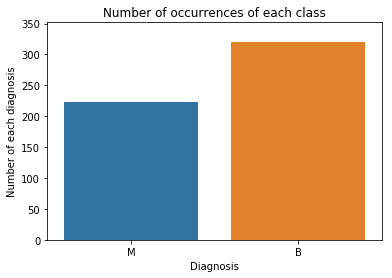

In [5]:
# Comparison of numbers of diagnoses
fig_1, ax_1 = plt.subplots()
sns.barplot(target_data.values, target_data.index, ax=ax_1, errwidth=0)
ax_1.set(title='Number of occurrences of each class', xlabel='Diagnosis', ylabel='Number of each diagnosis');

In [6]:
encoder = LabelEncoder()
encoded_target_data = encoder.fit_transform(target_data)

Much more _workable_. 

In [7]:
print(stats.describe(encoded_target_data))

DescribeResult(nobs=569, minmax=(0, 1), mean=0.37258347978910367, variance=0.23417658852941906, skewness=0.5270671676029054, kurtosis=-1.722200200835051)


The mean is 0.37, which makes sense given that the ratio of negative to positive is 1.7:1, which suggests a right skew, variance is 0.23, skewness is 0.53 (which is slightly right), and kurtosis is -1.72. 

There are 212 positive (malignant) and 357 negative (benign) instances in the dataset. I do not think that this is so unbalanced as to require weighting.  
Being binary nominal data, classification models are an easy pick for this, and it is fully linearly separable. 

### Feature Data
The feature data is continuous ratio data. 
#### Numeric
Each data sample is independent of each other data sample.  
It is a dense dataset.  None of it is missing. 

In [8]:
feature_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
Mean radius                         569 non-null float64
Mean texture                        569 non-null float64
Mean perimeter                      569 non-null float64
Mean area                           569 non-null float64
Mean smoothness                     569 non-null float64
Mean compactness                    569 non-null float64
Mean concavity                      569 non-null float64
Mean concave points                 569 non-null float64
Mean symmetry                       569 non-null float64
Mean fractal dimension              569 non-null float64
Standard error radius               569 non-null float64
Standard error texture              569 non-null float64
Standard error perimeter            569 non-null float64
Standard error area                 569 non-null float64
Standard error smoothness           569 non-null float64
Standard error compactness          569 

Nothing significant there. 

I have tried presenting the numerical statistical descriptions in a few different ways, but there are too many features and I've decided that that much numerical information is uselessly incomprehensible and just doesn't tell you anything you want to know, so I'm going to move to graphics now. 

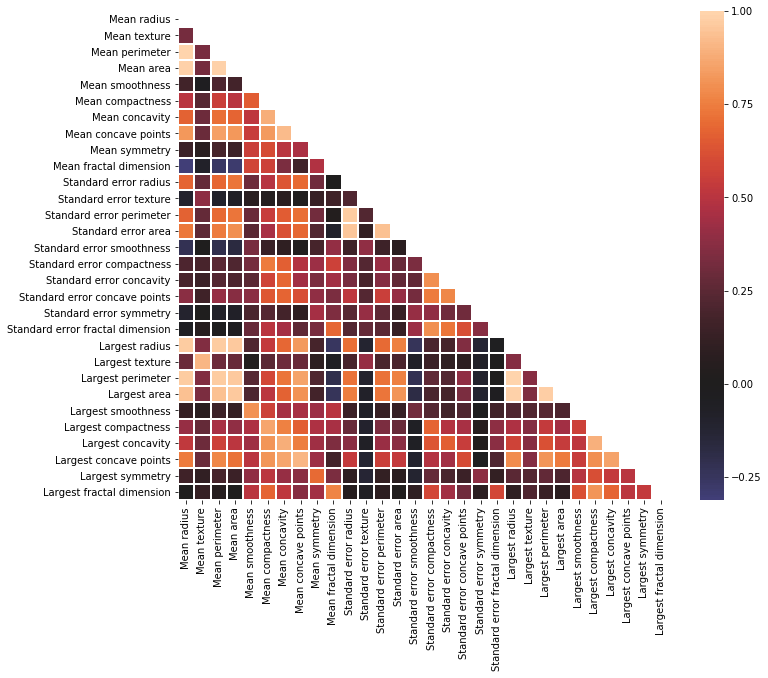

In [9]:
corr = wdbc_data.drop('ID number', axis=1).corr()
fig_2, ax_2 = plt.subplots(figsize=(11, 9))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, center=0, linewidths=1, mask=mask)

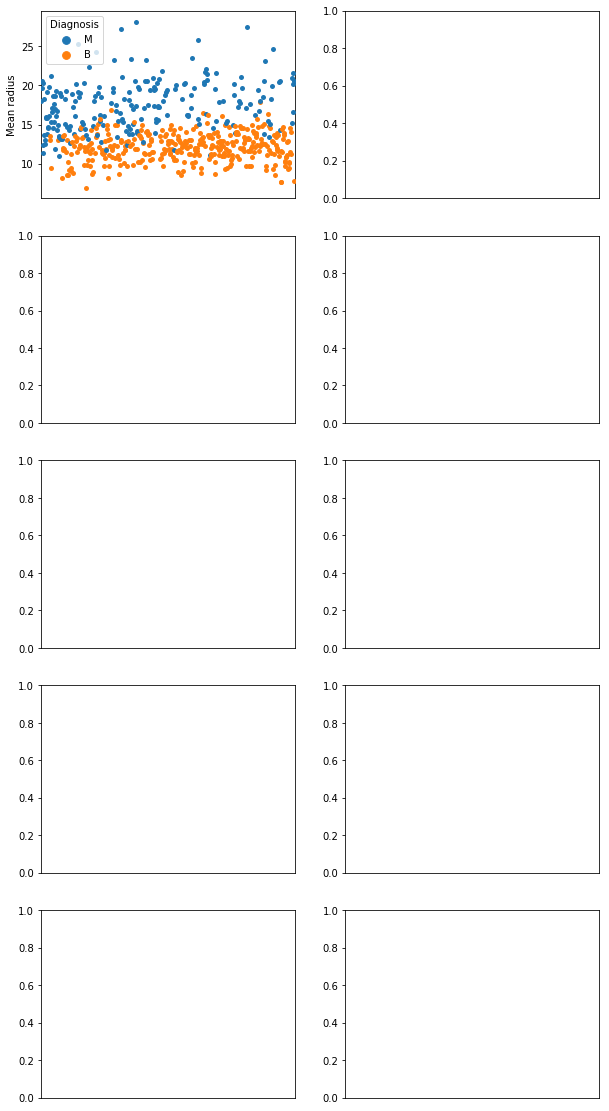

In [25]:
fig_3, ax_3 = plt.subplots(5, 2, figsize=(10, 20))

mean_swarmplot_data = wdbc_data.loc[:,'Diagnosis':'Mean fractal dimension']

sns.swarmplot(x=mean_swarmplot_data.index, y="Mean radius", hue="Diagnosis", data=swarmplot_data, ax=ax_3[0, 0]);
sns.swarmplot(x=mean_swarmplot_data.index, y="Mean texture", hue="Diagnosis", data=swarmplot_data, ax=ax_3[0, 1]);
sns.swarmplot(x=mean_swarmplot_data.index, y="Mean perimeter", hue="Diagnosis", data=swarmplot_data, ax=ax_3[1, 0]);
sns.swarmplot(x=mean_swarmplot_data.index, y="Mean area", hue="Diagnosis", data=swarmplot_data, ax=ax_3[1, 1]);
sns.swarmplot(x=mean_swarmplot_data.index, y="Mean smoothness", hue="Diagnosis", data=swarmplot_data, ax=ax_3[2, 0]);
sns.swarmplot(x=mean_swarmplot_data.index, y="Mean compactness", hue="Diagnosis", data=swarmplot_data, ax=ax_3[2, 1]);
sns.swarmplot(x=mean_swarmplot_data.index, y="Mean concavity", hue="Diagnosis", data=swarmplot_data, ax=ax_3[3, 0]);
sns.swarmplot(x=mean_swarmplot_data.index, y="Mean concave points", hue="Diagnosis", data=swarmplot_data, ax=ax_3[3, 1]);
sns.swarmplot(x=mean_swarmplot_data.index, y="Mean symmetry", hue="Diagnosis", data=swarmplot_data, ax=ax_3[4, 0]);
sns.swarmplot(x=mean_swarmplot_data.index, y="Mean fractal dimension", hue="Diagnosis", data=swarmplot_data, ax=ax_3[4, 1]);

for ax in ax_3.reshape(-1): 
    ax.set_xticks([])

plt.tight_layout()

In [ ]:
fig_4, ax_4 = plt.subplots(5, 2, figsize=(10, 20))

mean_swarmplot_data = wdbc_data.loc[:,'Diagnosis':'Mean fractal dimension']

sns.swarmplot(x=standard_error_swarmplot_data.index, y="Standard error radius", hue="Diagnosis", data=swarmplot_data, ax=ax_4[0, 0]);
sns.swarmplot(x=standard_error_swarmplot_data.index, y="Standard error texture", hue="Diagnosis", data=swarmplot_data, ax=ax_4[0, 1]);
sns.swarmplot(x=standard_error_swarmplot_data.index, y="Standard error perimeter", hue="Diagnosis", data=swarmplot_data, ax=ax_4[1, 0]);
sns.swarmplot(x=standard_error_swarmplot_data.index, y="Standard error area", hue="Diagnosis", data=swarmplot_data, ax=ax_4[1, 1]);
sns.swarmplot(x=standard_error_swarmplot_data.index, y="Standard error smoothness", hue="Diagnosis", data=swarmplot_data, ax=ax_4[2, 0]);
sns.swarmplot(x=standard_error_swarmplot_data.index, y="Standard error compactness", hue="Diagnosis", data=swarmplot_data, ax=ax_4[2, 1]);
sns.swarmplot(x=standard_error_swarmplot_data.index, y="Standard error concavity", hue="Diagnosis", data=swarmplot_data, ax=ax_4[3, 0]);
sns.swarmplot(x=standard_error_swarmplot_data.index, y="Standard error concave points", hue="Diagnosis", data=swarmplot_data, ax=ax_4[3, 1]);
sns.swarmplot(x=standard_error_swarmplot_data.index, y="Standard error symmetry", hue="Diagnosis", data=swarmplot_data, ax=ax_4[4, 0]);
sns.swarmplot(x=standard_error_swarmplot_data.index, y="Standard error fractal dimension", hue="Diagnosis", data=swarmplot_data, ax=ax_4[4, 1]);

for ax in ax_4.reshape(-1): 
    ax.set_xticks([])

plt.tight_layout()

In [ ]:
fig_5, ax_5 = plt.subplots(5, 2, figsize=(10, 20))

mean_swarmplot_data = wdbc_data.loc[:,'Diagnosis':'Mean fractal dimension']

sns.swarmplot(x=largest_swarmplot_data.index, y="Largest radius", hue="Diagnosis", data=swarmplot_data, ax=ax_5[0, 0]);
sns.swarmplot(x=largest_swarmplot_data.index, y="Largest texture", hue="Diagnosis", data=swarmplot_data, ax=ax_5[0, 1]);
sns.swarmplot(x=largest_swarmplot_data.index, y="Largest perimeter", hue="Diagnosis", data=swarmplot_data, ax=ax_5[1, 0]);
sns.swarmplot(x=largest_swarmplot_data.index, y="Largest area", hue="Diagnosis", data=swarmplot_data, ax=ax_5[1, 1]);
sns.swarmplot(x=largest_swarmplot_data.index, y="Largest smoothness", hue="Diagnosis", data=swarmplot_data, ax=ax_5[2, 0]);
sns.swarmplot(x=largest_swarmplot_data.index, y="Largest compactness", hue="Diagnosis", data=swarmplot_data, ax=ax_5[2, 1]);
sns.swarmplot(x=largest_swarmplot_data.index, y="Largest concavity", hue="Diagnosis", data=swarmplot_data, ax=ax_5[3, 0]);
sns.swarmplot(x=largest_swarmplot_data.index, y="Largest concave points", hue="Diagnosis", data=swarmplot_data, ax=ax_5[3, 1]);
sns.swarmplot(x=largest_swarmplot_data.index, y="Largest symmetry", hue="Diagnosis", data=swarmplot_data, ax=ax_5[4, 0]);
sns.swarmplot(x=largest_swarmplot_data.index, y="Largest fractal dimension", hue="Diagnosis", data=swarmplot_data, ax=ax_5[4, 1]);

for ax in ax_5.reshape(-1): 
    ax.set_xticks([])

plt.tight_layout()